<h5 style="color:rgba(0, 0, 178, 0.6);">Install librarys that we need</h5>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import TensorBoard
from keras.metrics import RootMeanSquaredError
from pathlib import Path
from time import strftime
import shap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
plt.style.use("bmh")
shap.initjs()

<h5 style="color:rgba(0, 0, 178, 0.6);">Read the data from data set</h5>

In [2]:
df = pd.read_csv("../../DATA/Data_increase.csv").drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
df["LLD-LLS"] = df.log_LLD - df.log_LLS
df["GR-GKUT"] = df.GR - df.GKUT
df.head()

,DEPT,GR,GKUT,NPHI,PE,RHOB,DRHO,well,log_LLS,log_LLD,LLD-LLS,GR-GKUT
0,2705.2524,19.0270,18.7281,0.0513,5.2064,2.6527,0.0198,1,0.699109,0.749381,0.050272,0.2989
1,2705.4048,15.8497,16.5070,0.0468,5.2632,2.6564,0.0229,1,0.708140,0.769960,0.061820,-0.6573
2,2705.5572,13.3455,14.3921,0.0411,5.2742,2.6546,0.0218,1,0.751779,0.823416,0.071636,-1.0466
3,2705.7096,12.2315,13.6969,0.0369,5.2543,2.6488,0.0202,1,0.787269,0.865447,0.078178,-1.4654
4,2705.8620,13.0494,13.2589,0.0322,5.1625,2.6475,0.0145,1,0.833886,0.921738,0.087852,-0.2095


<h5 style="color:rgba(0, 0, 178, 0.6);">plot the correlation matrix to see each parameters relation</h5>

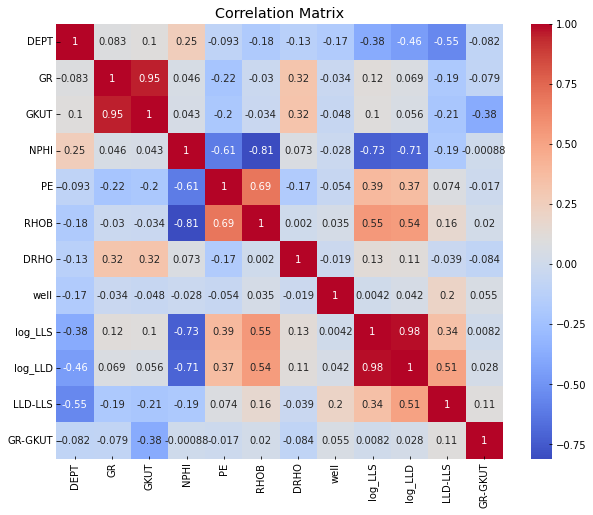

In [3]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<h5 style="color:rgba(0, 0, 178, 0.6);">Split data to; train and test ; X and y </h5>

In [5]:
train = df[~df['well'].isin(df.groupby("well").get_group(6)['well'])]
train = train[~train['well'].isin(train.groupby("well").get_group(4)['well'])]
test = df.groupby("well").get_group(6)
val = df.groupby("well").get_group(4)

X_train = train.drop(["NPHI", "RHOB","DRHO", "well"], axis=1)
y_train = train["NPHI"]

X_test = test.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)
y_test = test["NPHI"]

X_val = val.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)
y_val = val["NPHI"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
def model_creator():
    input_layer = keras.layers.Input(shape=(8))
    
    layer1 = keras.layers.Dense(135, "softsign", name="layer1")(input_layer)
    drop1 = keras.layers.Dropout(0.3)(layer1)
    
    layer2 = keras.layers.Dense(25, "mish", name="layer2")(drop1)
    drop2 = keras.layers.Dropout(0.3)(layer2)
    Norm2 = keras.layers.BatchNormalization()(drop2)
    
    layer3 = keras.layers.Dense(149, "softmax", name="layer3")(Norm2)
    Norm3 = keras.layers.BatchNormalization()(layer3)
    
    layer4 = keras.layers.Dense(82, "softsign", name="layer4")(Norm3)
    drop4 = keras.layers.Dropout(0.3)(layer4)

    
    output_layer = keras.layers.Dense(1, "linear", name="output_layer")(drop4)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    optimizer =keras.optimizers.Adamax(learning_rate=0.01)
    model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError()])
    return model

<h5 style="color:rgba(0, 0, 178, 0.6);">bild model from GA and create dir for tensorbord </h5>

Epoch 1/1000
111/111 [==============================] - 2s 8ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809
Epoch 2/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 3/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 4/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 5/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 6/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0

Epoch 48/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 49/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 50/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 51/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 52/1000
111/111 [==============================] - 1s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 53/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_l

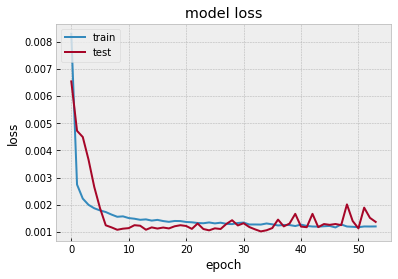

43/43 [==============================] - 0s 2ms/step
0.7674693750950508


In [54]:
model = model_creator()
    
    
# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"model_best.h5", save_weights_only=True,best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                batch_size=135,
                callbacks=[early_stopping_cb,checkpoint_cb],
                validation_data=(X_val, y_val),
                epochs=1000,
                verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(r2_score(y_test, model.predict(X_test)))

In [6]:
from keras.models import load_model
model = model_creator()

model.load_weights("model_best.h5")

In [7]:
print("best_model:R2")
print(r2_score(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))

best_model:R2
43/43 [==============================] - 0s 2ms/step
0.7674693750950508
43/43 [==============================] - 0s 1ms/step
0.023594406733815076
43/43 [==============================] - 0s 1ms/step
0.0009273494277568216


In [8]:
print("best_model:R2")
print(r2_score(y_val, model.predict(X_val)))
print(mean_absolute_error(y_val, model.predict(X_val)))
print(mean_squared_error(y_val, model.predict(X_val)))

best_model:R2
38/38 [==============================] - 0s 1ms/step
0.7004149316908547
38/38 [==============================] - 0s 1ms/step
0.024582042257862452
38/38 [==============================] - 0s 1ms/step
0.0010243156299757595


In [9]:
print("best_model:R2")
print(r2_score(y_train, model.predict(X_train)))
print(mean_absolute_error(y_train, model.predict(X_train)))
print(mean_squared_error(y_train, model.predict(X_train)))

best_model:R2
466/466 [==============================] - 1s 1ms/step
0.7867284625468218
466/466 [==============================] - 1s 1ms/step
0.02313314405261037
466/466 [==============================] - 1s 1ms/step
0.0010291734966707557


In [25]:
for layer in model.layers[:-1]:
    print(layer.get_weights()[0])

IndexError: list index out of range

In [33]:
# # train XGBoost model
# model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(
#     X_adult, y_adult * 1, eval_metric="logloss"
# )

# compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# set a display version of the data to use for plotting (has string values)
# shap_values.display_data = shap.datasets.adult(display=True)[0].values



ExactExplainer explainer: 14892it [11:38, 21.01it/s]                                                                   


In [36]:
train.head()

,DEPT,GR,GKUT,NPHI,PE,RHOB,DRHO,well,log_LLS,log_LLD,LLD-LLS,GR-GKUT
0,2705.2524,19.0270,18.7281,0.0513,5.2064,2.6527,0.0198,1,0.699109,0.749381,0.050272,0.2989
1,2705.4048,15.8497,16.5070,0.0468,5.2632,2.6564,0.0229,1,0.708140,0.769960,0.061820,-0.6573
2,2705.5572,13.3455,14.3921,0.0411,5.2742,2.6546,0.0218,1,0.751779,0.823416,0.071636,-1.0466
3,2705.7096,12.2315,13.6969,0.0369,5.2543,2.6488,0.0202,1,0.787269,0.865447,0.078178,-1.4654
4,2705.8620,13.0494,13.2589,0.0322,5.1625,2.6475,0.0145,1,0.833886,0.921738,0.087852,-0.2095


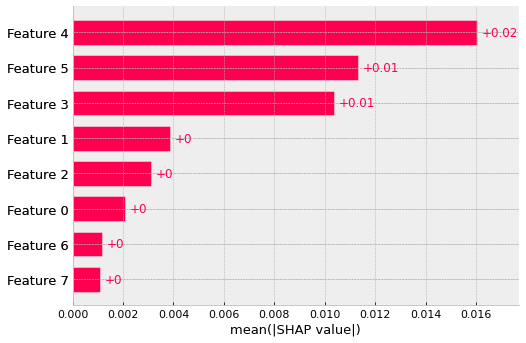

In [18]:
shap.plots.bar(shap_values)


In [10]:
X_train_ = train.drop(["NPHI", "RHOB","DRHO", "well", "DEPT"], axis=1)
y_train_ = train["NPHI"]

X_test_ = test.drop(["DEPT", "NPHI", "RHOB", "DRHO", "well"], axis=1)
y_test_ = test["NPHI"]

In [17]:
# Initialize the SHAP explainer
explainer = shap.Explainer(model, X_test)

# Compute the SHAP values
shap_values = explainer(X_test)

ExactExplainer explainer: 1358it [01:15, 16.43it/s]                                                                    


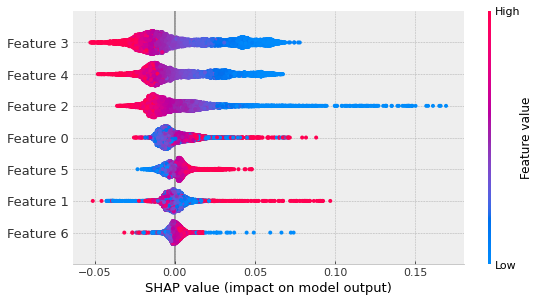

In [12]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_train)


In [51]:
np.shape(y_test)

(1357,)

43/43 [==============================] - 0s 1ms/step


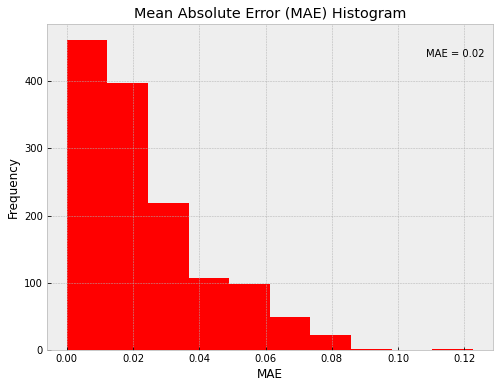

In [10]:
# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X_val)
mae = np.abs(y_test - np.reshape(y_pred,(np.shape(y_pred)[0],)))
MAE = np.sum(mae)/(len(y_pred))
# Plot the MAE histogram
plt.figure(figsize=(8, 6))
plt.hist(mae, color="r")
# , bins=3, edgecolor='red'
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Mean Absolute Error (MAE) Histogram')
plt.text(0.85, 0.9, f"MAE = {MAE:.2f}", transform=plt.gca().transAxes)
plt.savefig("MAE.png")
plt.show()

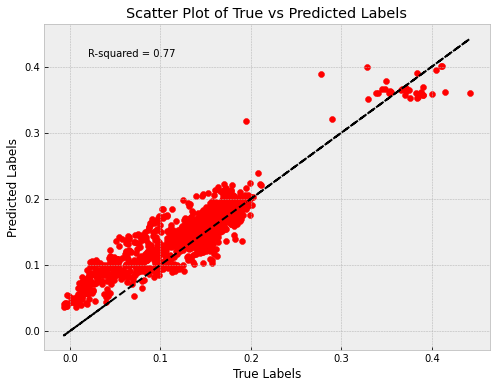

In [11]:
# y_pred = np.reshape(y_pred,(1357,))
# Plot the scatter plot
r2 = r2_score(y_test, y_pred)
plt.figure(figsize=(8, 6))

plt.plot(y_test,y_test, linestyle = 'dashed', color="black")
plt.scatter(y_test, y_pred, color="r")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels')
plt.text(0.1, 0.9, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)
plt.savefig("sctatter.png")
plt.show()

In [16]:
fmri

NameError: name 'fmri' is not defined

In [13]:
y_pred = np.reshape(y_pred, (1357,))

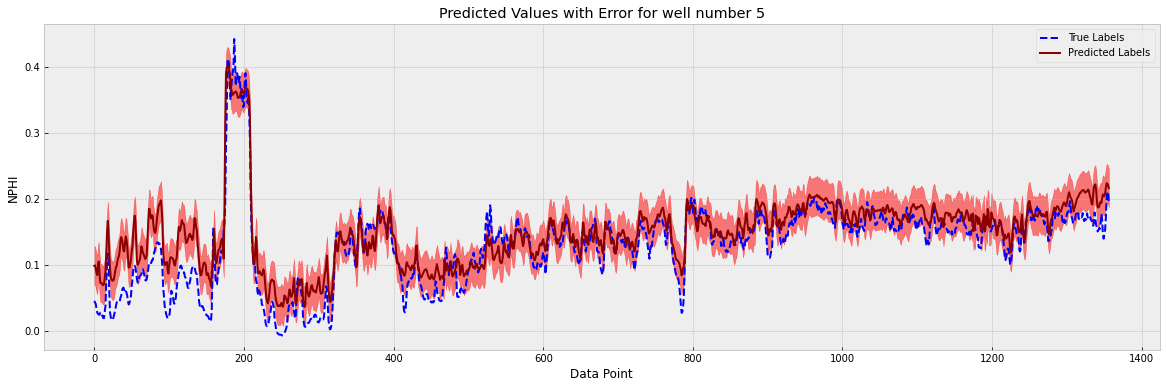

In [14]:
y_true = y_test.values
# Calculate the error between true and predicted labels
error = y_true - y_pred

# Plot the predicted values and error
plt.figure(figsize=(20, 6))
plt.plot(y_true, label='True Labels', color="b", alpha=1, linestyle = 'dashed')
plt.plot(y_pred, label='Predicted Labels', color="darkred")
plt.fill_between(range(len(y_true)), y_pred-0.029, y_pred+0.029, alpha=0.5, color='red')

plt.xlabel('Data Point')
plt.ylabel('NPHI')
plt.title('Predicted Values with Error for well number 5')
plt.legend()
plt.savefig("plot.png")
plt.show()

In [26]:
df['well'].unique()

array([1, 2, 3, 4, 6, 7], dtype=int64)

In [36]:
well1.head()

,DEPT,GR,GKUT,NPHI,PE,RHOB,DRHO,well,log_LLS,log_LLD,LLD-LLS,GR-GKUT
0,2705.2524,19.0270,18.7281,0.0513,5.2064,2.6527,0.0198,1,0.699109,0.749381,0.050272,0.2989
1,2705.4048,15.8497,16.5070,0.0468,5.2632,2.6564,0.0229,1,0.708140,0.769960,0.061820,-0.6573
2,2705.5572,13.3455,14.3921,0.0411,5.2742,2.6546,0.0218,1,0.751779,0.823416,0.071636,-1.0466
3,2705.7096,12.2315,13.6969,0.0369,5.2543,2.6488,0.0202,1,0.787269,0.865447,0.078178,-1.4654
4,2705.8620,13.0494,13.2589,0.0322,5.1625,2.6475,0.0145,1,0.833886,0.921738,0.087852,-0.2095


In [15]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)

NPHI1_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI2_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI3_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI4_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI5_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI6_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])


NPHI1_log["DEPT"], NPHI1_log["well_NPHI"], NPHI1_log["well_pridct"] = well1["DEPT"], well1["NPHI"], model.predict(scaler.transform(well1.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI2_log["DEPT"], NPHI2_log["well_NPHI"], NPHI2_log["well_pridct"] = well2["DEPT"], well2["NPHI"], model.predict(scaler.transform(well2.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI3_log["DEPT"], NPHI3_log["well_NPHI"], NPHI3_log["well_pridct"] = well3["DEPT"], well3["NPHI"], model.predict(scaler.transform(well3.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI4_log["DEPT"], NPHI4_log["well_NPHI"], NPHI4_log["well_pridct"] = well4["DEPT"], well4["NPHI"], model.predict(scaler.transform(well4.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI5_log["DEPT"], NPHI5_log["well_NPHI"], NPHI5_log["well_pridct"] = well6["DEPT"], well6["NPHI"], model.predict(scaler.transform(well6.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI6_log["DEPT"], NPHI6_log["well_NPHI"], NPHI6_log["well_pridct"] = well7["DEPT"], well7["NPHI"], model.predict(scaler.transform(well7.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))



NPHIs_log = [NPHI1_log,
             NPHI2_log,
             NPHI3_log,
             NPHI4_log,
             NPHI5_log,
             NPHI6_log]

59/59 [==============================] - 0s 1ms/step


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose l

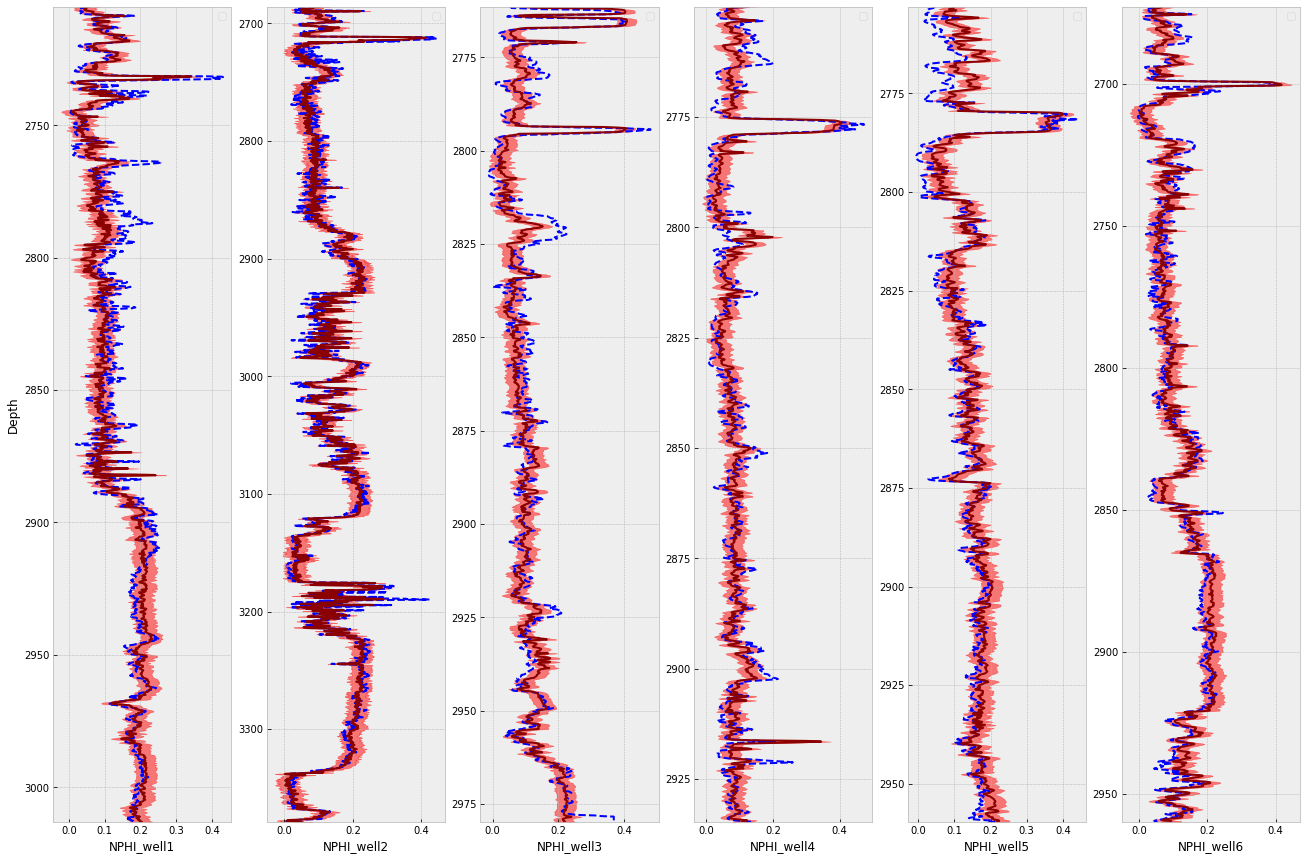

In [16]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')
plt.savefig("all_wells.png")
plt.show()

In [21]:
train = df[~df['well'].isin(df.groupby("well").get_group(2)['well'])]
test = df.groupby("well").get_group(2)

X_train = train.drop(["NPHI", "RHOB","DRHO", "well"], axis=1).values
y_train = train["NPHI"].values

X_test = test.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1).values
y_test = test["NPHI"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Epoch 1/1000
59/59 [==============================] - 2s 16ms/step - loss: 0.1294 - root_mean_squared_error: 0.3598 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2896
Epoch 2/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869
Epoch 3/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 4/1000
59/59 [==============================] - 1s 21ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 5/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0758
Epoch 6/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0055 

Epoch 48/1000
59/59 [==============================] - 1s 12ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 8.7925e-04 - val_root_mean_squared_error: 0.0297
Epoch 49/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 50/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 8.7349e-04 - val_root_mean_squared_error: 0.0296
Epoch 51/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 8.6772e-04 - val_root_mean_squared_error: 0.0295
Epoch 52/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0015 - root_mean_squared_error: 0.0394 - val_loss: 9.6560e-04 - val_root_mean_squared_error: 0.0311
Epoch 53/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0016 - root_mean_squared_error: 0.03

59/59 [==============================] - 1s 11ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 7.6181e-04 - val_root_mean_squared_error: 0.0276
Epoch 141/1000
59/59 [==============================] - 1s 12ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 7.5471e-04 - val_root_mean_squared_error: 0.0275
Epoch 142/1000
59/59 [==============================] - 1s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 6.7882e-04 - val_root_mean_squared_error: 0.0261
Epoch 143/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 8.1697e-04 - val_root_mean_squared_error: 0.0286
Epoch 144/1000
59/59 [==============================] - 1s 10ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 9.5306e-04 - val_root_mean_squared_error: 0.0309
Epoch 145/1000
59/59 [==============================] - 1s 12ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - v

Epoch 186/1000
59/59 [==============================] - 1s 11ms/step - loss: 9.6685e-04 - root_mean_squared_error: 0.0311 - val_loss: 9.6173e-04 - val_root_mean_squared_error: 0.0310
Epoch 187/1000
59/59 [==============================] - 1s 13ms/step - loss: 9.8556e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0367
Epoch 188/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 8.0177e-04 - val_root_mean_squared_error: 0.0283
Epoch 189/1000
59/59 [==============================] - 1s 12ms/step - loss: 9.7919e-04 - root_mean_squared_error: 0.0313 - val_loss: 8.5616e-04 - val_root_mean_squared_error: 0.0293
Epoch 190/1000
59/59 [==============================] - 1s 11ms/step - loss: 9.8220e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 191/1000
59/59 [==============================] - 1s 11ms/step - loss: 0.0010 - root_mean_s

Epoch 231/1000
59/59 [==============================] - 1s 11ms/step - loss: 9.6593e-04 - root_mean_squared_error: 0.0311 - val_loss: 8.1403e-04 - val_root_mean_squared_error: 0.0285
Epoch 232/1000
59/59 [==============================] - 1s 12ms/step - loss: 9.3517e-04 - root_mean_squared_error: 0.0306 - val_loss: 7.2346e-04 - val_root_mean_squared_error: 0.0269
Epoch 233/1000
59/59 [==============================] - 1s 11ms/step - loss: 9.2123e-04 - root_mean_squared_error: 0.0304 - val_loss: 7.7289e-04 - val_root_mean_squared_error: 0.0278
Epoch 234/1000
59/59 [==============================] - 1s 13ms/step - loss: 8.9804e-04 - root_mean_squared_error: 0.0300 - val_loss: 8.1493e-04 - val_root_mean_squared_error: 0.0285
Epoch 235/1000
59/59 [==============================] - 1s 10ms/step - loss: 9.0941e-04 - root_mean_squared_error: 0.0302 - val_loss: 7.8751e-04 - val_root_mean_squared_error: 0.0281
Epoch 236/1000
59/59 [==============================] - 1s 13ms/step - loss: 9.1946e-

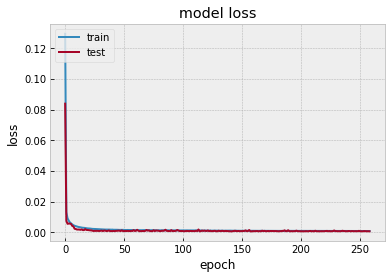

143/143 [==============================] - 0s 2ms/step
0.87744279120493


In [22]:
model = model_creator()
    
    
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"model_best.h5", save_weights_only=True,best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

history = model.fit(X_train, y_train,
                batch_size=220,
                callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb],
                validation_data=(X_test, y_test),
                epochs=1000,
                verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(r2_score(y_test, model.predict(X_test)))

In [24]:
len(y_pred)

4550

143/143 [==============================] - 0s 1ms/step


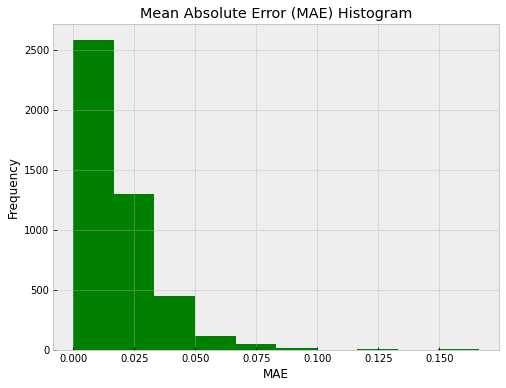

In [25]:
# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X_test)
mae = np.abs(y_test - np.reshape(y_pred,(4550,)))

# Plot the MAE histogram
plt.figure(figsize=(8, 6))
plt.hist(mae, color="green")
# , bins=3, edgecolor='red'
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Mean Absolute Error (MAE) Histogram')
plt.show()

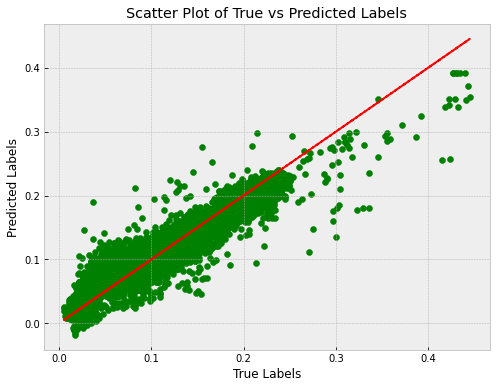

In [26]:
y_pred = np.reshape(y_pred,(4550,))
# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="green")
plt.plot(y_test,y_test, linestyle = 'dashed', color="red")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels')
plt.show()

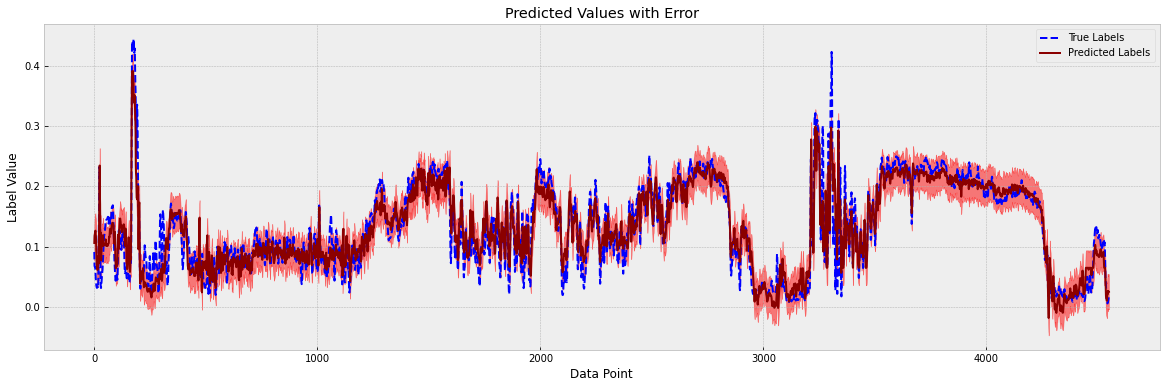

In [27]:
y_true = y_test
# Calculate the error between true and predicted labels
error = y_true - y_pred

# Plot the predicted values and error
plt.figure(figsize=(20, 6))
plt.plot(y_true, label='True Labels', color="b", alpha=1, linestyle = 'dashed')
plt.plot(y_pred, label='Predicted Labels', color="darkred")
plt.fill_between(range(len(y_true)), y_pred-0.029, y_pred+0.029, alpha=0.5, color='red')

plt.xlabel('Data Point')
plt.ylabel('Label Value')
plt.title('Predicted Values with Error')
plt.legend()
plt.show()

In [28]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
# well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)



NPHI1_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI2_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI3_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI4_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI5_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI6_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])


NPHI1_log["DEPT"], NPHI1_log["well_NPHI"], NPHI1_log["well_pridct"] = well1["DEPT"], well1["NPHI"], model.predict(scaler.transform(well1.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI2_log["DEPT"], NPHI2_log["well_NPHI"], NPHI2_log["well_pridct"] = well2["DEPT"], well2["NPHI"], model.predict(scaler.transform(well2.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI3_log["DEPT"], NPHI3_log["well_NPHI"], NPHI3_log["well_pridct"] = well3["DEPT"], well3["NPHI"], model.predict(scaler.transform(well3.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI4_log["DEPT"], NPHI4_log["well_NPHI"], NPHI4_log["well_pridct"] = well4["DEPT"], well4["NPHI"], model.predict(scaler.transform(well4.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI5_log["DEPT"], NPHI5_log["well_NPHI"], NPHI5_log["well_pridct"] = well6["DEPT"], well6["NPHI"], model.predict(scaler.transform(well6.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI6_log["DEPT"], NPHI6_log["well_NPHI"], NPHI6_log["well_pridct"] = well7["DEPT"], well7["NPHI"], model.predict(scaler.transform(well7.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))





NPHIs_log = [NPHI1_log,
             NPHI2_log,
             NPHI3_log,
             NPHI4_log,
             NPHI5_log,
             NPHI6_log]

64/64 [==============================] - 0s 1ms/step


X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


 1/38 [..............................] - ETA: 0s

X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


43/43 [==============================] - 0s 1ms/step


X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


59/59 [==============================] - 0s 2ms/step


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose l

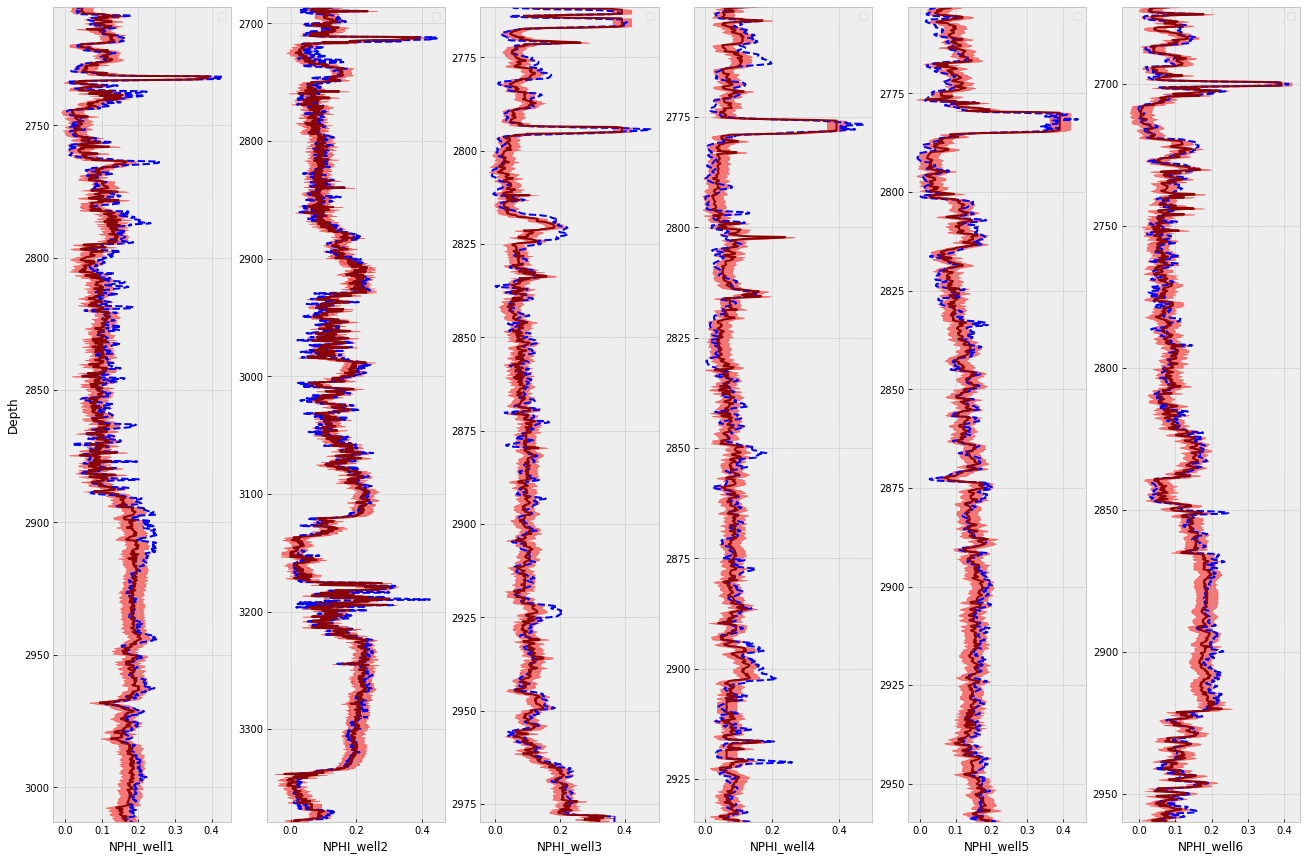

In [29]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')

plt.show()

In [20]:
# Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute the SHAP values
shap_values = explainer(X_train)

ExactExplainer explainer:   8%|███▉                                               | 1159/14891 [01:01<13:28, 16.98it/s]


KeyboardInterrupt: 

In [ ]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_train)

In [ ]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)


In [ ]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')

plt.show()